# RAG System Component Evaluation
    
This notebook is a follow up from the previous [notebook](https://github.com/fhuthmacher/LLMevaluation/blob/main/LLMInformationExtraction.ipynb) and [youtube video](https://www.youtube.com/watch?v=HUuO9eJbOTk) in which we explored the overall evaluation approach and a RAG system's overall accuracy.

In this notebook we will take a closer look at specific RAG evaluation metrics and explore how different RAG components impact these RAG evaluation metrics.


## Solution architecture
<img src="./images/architecture.png" alt="RAG eval architecture" width="900" height="550">

From the solution architecture, we will experiment with the below RAG components and evaluate the impact on several metric's relevant for RAG.

- 1) Text Splitter: TokenTextSplitter vs CharacterTextSplitter
- 2) Embedding model: amazon.titan-embed-text-v1 vs cohere.embed-multilingual-v3 
- 3) Retriever: OpenSearch VectoreStoreRetriever search types “similarity” vs “mmr” vs Bedrock KnowledgeBase retriever
- 4) Prompt Template: For each LLM we evaluate two different prompt templates


## RAG evaluation metrics

This notebook covers the following metrics:
1) RAGAS:
-  a. context_precision: evaluates whether all of the ground-truth relevant items are present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks. Values range from 0 to 1, higher scores indicate better precision.
-  b. context_recall: measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. Values range from 0 to 1, with higher values indicating better performance.
-  c. answer_relevancy: focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information. This metric is computed using the question and the answer, with values ranging between 0 and 1 where higher scores indicate better relevancy.
-  d. answer_correctness¶: the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1  where higher scores indicate better relevancy.
-  e. answer_similarity: Scores the semantic similarity of ground truth with generated answer, with values ranging between 0 and 1 where higher scores indicate better relevancy.
- f. faithfulness: measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. Values range from 0 to 1, with higher values indicating better performance.

Further information on RAG evaluation metrics with RAGAS can be found [here](https://docs.ragas.io/en/latest/concepts/metrics/index.html).


2) LlamaIndex: 
-  a. Faithfulness: measure if the response from a query engine matches any source nodes. Returns a score between 0 and 1, where 1 means the response is faithful to the retrieved contexts.
-  b. Relevancy: measure if the response and source nodes match the query. Returns a score that is between 0 and 1 as well as a generated feedback explaining the score, higher score means higher relevancy. 
-  c. Correctness: assess the relevance and correctness of a generated answer against a reference answer. Returns a score between 0 and 5, where 5 means the response is correct.
-  d. Semantic Similarity: evaluates the quality of a question answering system via semantic similarity, values ranging between 0 and 1 where higher scores indicate better relevancy.

Further information on LlamaIndex Evaluators can be found [here](https://docs.llamaindex.ai/en/stable/module_guides/evaluating/).

In our analysis we primarily focus on the following RAGAS metrics: context precision, context recall, faithfulness, and answer relevance.

Intuitively we expect to see a strong correlation between respective RAGAS and LlamaIndex Evaluator metrics.

While this notebook tracks metrics with mlflow, it is not required for the evaluation. If you want to learn more about how to configure mlflow in your environment, please refer to this [AWS Blog](https://aws.amazon.com/blogs/machine-learning/securing-mlflow-in-aws-fine-grained-access-control-with-aws-native-services/).

<img src="./images/RAGevalmetrics.png" alt="RAG eval metrics" width="900" height="550">

In [4]:
# check installed packages
with open('requirements.txt') as f:
  requirements = f.readlines()

import pkg_resources

installed_packages = [d for d in pkg_resources.working_set]

installed_packages = [package.project_name for package in installed_packages]

missing_packages = []

for requirement in requirements:
  requirement = requirement.strip().split('==')[0]
  if requirement not in installed_packages and requirement !='./ragas-aws-1.0.tar.gz':
    missing_packages.append(requirement)

if missing_packages:
  print(f"Missing packages: {', '.join(missing_packages)}")
else: 
  print("All packages are installed")



All packages are installed


In [5]:
# if there are any missing dependencies, install packages
if missing_packages:
    # install dependencies
    %pip install --force-reinstall --no-cache -r requirements.txt

In [3]:
#!pip install --upgrade jupyter-console
!pip install --upgrade jupyter

In [6]:
# restart kernel to ensure proper version of libraries is loaded
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()

In [7]:
!pip list | grep -E "awscli|boto3|botocore|langchain|llama-index|plotly|tiktoken|nltk|python-dotenv|ragas|requests-aws4auth|pypdf|opensearch-py|sagemaker|nest-asyncio"
# also review requirements.txt for specific package versions if needed

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


awscli                                  1.32.87
boto3                                   1.34.87
botocore                                1.34.87
langchain                               0.1.16
langchain-community                     0.0.34
langchain-core                          0.1.45
langchain-openai                        0.1.3
langchain-text-splitters                0.0.1
langchainhub                            0.1.15
llama-index                             0.9.38
llama-index-agent-openai                0.2.2
llama-index-cli                         0.1.11
llama-index-core                        0.10.28
llama-index-embeddings-openai           0.1.7
llama-index-indices-managed-llama-cloud 0.1.5
llama-index-legacy                      0.9.48
llama-index-llms-openai                 0.1.15
llama-index-multi-modal-llms-openai     0.1.5
llama-index-program-openai              0.1.5
llama-index-question-gen-openai         0.1.3
llama-index-readers-file                0.1.16
llama-index-reade

In [8]:
# load environment variables 
import boto3
import os
import botocore
from botocore.config import Config
import langchain
import sagemaker
import pandas as pd

from langchain.llms.bedrock import Bedrock
from langchain.llms import SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from typing import Dict

import json
import requests
import csv
import time
import pandas as pd
import nltk
import sys

from langchain.llms import Bedrock
from dotenv import load_dotenv, find_dotenv
import mlflow
from mlflow import MlflowClient


# loading environment variables that are stored in local file dev.env
load_dotenv(find_dotenv('dev-mlflow.env'),override=True)

os.environ['OPENSEARCH_COLLECTION'] = os.getenv('OPENSEARCH_COLLECTION')
os.environ['BEDROCK_KNOWLEDGEBASE_ID'] = os.getenv('BEDROCK_KNOWLEDGEBASE_ID')
os.environ['REGION'] = os.getenv('REGION')
os.environ['MLFLOW_TRACKING_ENABLED'] = os.getenv('MLFLOW_TRACKING_ENABLED')
os.environ['MLFLOW_TRACKING_URI'] = os.getenv('MLFLOW_TRACKING_URI')

if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
   # Initialize mlflow client
   mlflow_client = MlflowClient(tracking_uri=os.environ['MLFLOW_TRACKING_URI'])


# Initialize Bedrock runtime
config = Config(
   retries = {
      'max_attempts': 8
   }
)
bedrock_runtime = boto3.client(
        service_name="bedrock-runtime",
        config=config
)

# Initialize sagemaker session
session = sagemaker.Session()
bucket = session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [9]:
# Create a new mlflow experiment
import random

if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
    experiment_description = (
        "RAG system evaluation project."
    )

    experiment_tags = {
        "project_name": "rag-eval",
        "use_case": "information extraction",
        "team": "aws-ai-ml-analytics",
        "source": "Amazon 10k",
        "mlflow.note.content": experiment_description,
    }

    random_identifier = random.randrange(100, 1000, 3)
    experiment_name = f"RAG_system_accuracy_{random_identifier}"
    llm_experiment = mlflow_client.create_experiment(name=experiment_name, tags=experiment_tags)

    # Use search_experiments() to search on the project_name tag key
    rag_experiment = mlflow_client.search_experiments(
        filter_string="tags.`project_name` = 'rag-eval'"
    )

    print(rag_experiment[0])

<Experiment: artifact_location='s3://mlflow-artifacts-026459568683/46', creation_time=1713834767299, experiment_id='46', last_update_time=1713834767299, lifecycle_stage='active', name='RAG_system_accuracy_520', tags={'mlflow.note.content': 'RAG system evaluation project.',
 'project_name': 'rag-eval',
 'source': 'Amazon 10k',
 'team': 'aws-ai-ml-analytics',
 'use_case': 'information extraction'}>


In [10]:
# 1. Initialize LLMs (Claude-V2, Cohere, LLama2)

## 1a. Initialize Claude-v2
llm01_inference_modifier = {
    "max_tokens_to_sample": 545,
    "temperature": 0,
    "stop_sequences": ["\n\nHuman"],
}
LLM_01_NAME= "anthropic.claude-v2"
llm01 = langchain.llms.bedrock.Bedrock( #create a Bedrock llm client
    model_id=LLM_01_NAME,
    model_kwargs=llm01_inference_modifier
)

## 1b. Initialize Cohere Command
llm02_inference_modifier = { 
    "max_tokens": 545,
    "temperature": 0,    
}
LLM_02_NAME= "cohere.command-text-v14"
llm02 = langchain.llms.bedrock.Bedrock( #create a Bedrock llm client
    model_id=LLM_02_NAME,
    model_kwargs=llm02_inference_modifier
)

## 1c. Initialize Llama
llm03_inference_modifier = { 
    "max_gen_len": 545,
    "top_p": 0.9, 
    "temperature": 0,    
}
LLM_03_NAME= "meta.llama2-13b-chat-v1"
llm03 = langchain.llms.bedrock.Bedrock( #create a Bedrock llm client
    model_id=LLM_03_NAME,
    model_kwargs=llm03_inference_modifier
)

llms = [
    llm01,
    llm02,
    llm03
]


/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Bedrock` was deprecated in LangChain 0.0.34 and will be removed in 0.3. An updated version of the class exists in the langchain-aws package and should be used instead. To use it run `pip install -U langchain-aws` and import as `from langchain_aws import BedrockLLM`.
  warn_deprecated(


In [11]:
## 2. Download ground truth dataset

import xmltodict
url = 'https://d3q8adh3y5sxpk.cloudfront.net/rageval/qsdata_20.xml'

# Send an HTTP GET request to download the file
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:        
    xml_data = xmltodict.parse(response.text)

# Convert the dictionary to a Pandas DataFrame
qa_dataset = pd.DataFrame(xml_data['data']['records'])

prompts = []
for row in qa_dataset.itertuples():
    item = {
        'prompt': str(row[1]['Question']),
        'context': str(row[1]['Context']),
        'output': str(row[1]['Answer']['question_answer']),
        'page': str(row[1]['Page'])
    }
    prompts.append(item)

# example prompt
print(prompts[0])

{'prompt': "Who is Amazon's Senior Vice President and General Counsel?", 'context': 'Available Information\nOur investor relations website is amazon.com/ir and we encourage investors to use it as a way of easily finding information about us. We promptly make available on this website, free of charge, the reports that we file or furnish with the Securities and Exchange Commission (â\x80\x9cSECâ\x80\x9d), corporate governance information (including our Code of Business Conduct and Ethics), and select press releases.\nExecutive Officers and Directors\nThe following tables set forth certain information regarding our Executive Officers and Directors as of January 25, 2023:\nInformation About Our Executive Officers\nName Age Position\nJeffrey P. Bezos. Mr. Bezos founded Amazon.com in 1994 and has served as Executive Chair since July 2021. He has served as Chair of the Board since 1994 and served as Chief Executive Officer from May 1996 until July 2021, and as President from 1994 until June 1

In [12]:
# 3. Download context / Amazon annual report and create documents
import numpy as np
import pypdf
from langchain.text_splitter import CharacterTextSplitter, TokenTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from urllib.request import urlretrieve

os.makedirs("data", exist_ok=True)
files = [ "https://d3q8adh3y5sxpk.cloudfront.net/rageval/AMZN-2023-10k.pdf"]
for url in files:
    file_path = os.path.join("data", url.rpartition("/")[2])
    urlretrieve(url, file_path)
    

loader = PyPDFDirectoryLoader("./data/")
documents = loader.load()

In [13]:
# 4. Create or get vector database (OpenSearch Serverless)
## Provisioning below resources requires signficant access. 
## Thus if you do not have admin access or already have an existing OpenSearch Serverless endpoint and Bedrock Knowledge Base, you can just update the corresponding variable in dev-mlflow.env

import time
import os
import dotenv
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

host = os.environ['OPENSEARCH_COLLECTION']  # serverless collection endpoint, without https://
#print(f"host: {host}")
region = os.environ['REGION']  # e.g. us-east-1
print(f'region: {region}')

service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

## 4a. create vectordatabase if it does not exist yet
if host == 'XXX':
    print('creating collection')
    vector_store_name = 'rag-eval'
    encryption_policy_name = "rag-eval-ep"
    network_policy_name = "rag-eval-np"
    access_policy_name = 'rag-eval-ap'
    identity = boto3.client('sts').get_caller_identity()['Arn']

    aoss_client = boto3.client('opensearchserverless')

    security_policy = aoss_client.create_security_policy(
        name = encryption_policy_name,
        policy = json.dumps(
            {
                'Rules': [{'Resource': ['collection/' + vector_store_name],
                'ResourceType': 'collection'}],
                'AWSOwnedKey': True
            }),
        type = 'encryption'
    )

    network_policy = aoss_client.create_security_policy(
        name = network_policy_name,
        policy = json.dumps(
            [
                {'Rules': [{'Resource': ['collection/' + vector_store_name],
                'ResourceType': 'collection'}],
                'AllowFromPublic': True}
            ]),
        type = 'network'
    )

    collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

    while True:
        status = aoss_client.list_collections(collectionFilters={'name':vector_store_name})['collectionSummaries'][0]['status']
        if status in ('ACTIVE', 'FAILED'): 
            print(f'new collection {vector_store_name} created')
            break
        time.sleep(10)

    access_policy = aoss_client.create_access_policy(
        name = access_policy_name,
        policy = json.dumps(
            [
                {
                    'Rules': [
                        {
                            'Resource': ['collection/' + vector_store_name],
                            'Permission': [
                                'aoss:CreateCollectionItems',
                                'aoss:DeleteCollectionItems',
                                'aoss:UpdateCollectionItems',
                                'aoss:DescribeCollectionItems'],
                            'ResourceType': 'collection'
                        },
                        {
                            'Resource': ['index/' + vector_store_name + '/*'],
                            'Permission': [
                                'aoss:CreateIndex',
                                'aoss:DeleteIndex',
                                'aoss:UpdateIndex',
                                'aoss:DescribeIndex',
                                'aoss:ReadDocument',
                                'aoss:WriteDocument'],
                            'ResourceType': 'index'
                        }],
                    'Principal': [identity],
                    'Description': 'Easy data policy'}
            ]),
        type = 'data'
    )
    print(collection)
    host = collection['createCollectionDetail']['id'] + '.' + os.environ.get("AWS_DEFAULT_REGION", None) + '.aoss.amazonaws.com:443'
    host = host.split(":")[0].replace("'","")
    # Write changes to .env file.
    os.environ['OPENSEARCH_COLLECTION'] = host
    dotenv.set_key('dev-mlflow.env', "OPENSEARCH_COLLECTION", os.environ["OPENSEARCH_COLLECTION"])

aospy_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20,
)

## 4b. create Bedrock KnowledgeBase if it does not exist yet

if os.environ['BEDROCK_KNOWLEDGEBASE_ID'] == "XXX":
    knowledge_base_id = ""
    session = sagemaker.Session()

    # please note this requires significant permissions, thus might have to be done outside of the notebook if your user role has insufficient access.
    print('create knowledge base')

    print(f'using the following S3 bucket as source: {bucket}')
    prefix = "bedrock-kb-eval"

    # upload source data to S3
    s3 = boto3.client('s3')
    s3.upload_file('./data/AMZN-2023-10k.pdf', bucket, 'rageval/AMZN-2023-10k.pdf')

    #session.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'rageval/AMZN-2023-10k.pdf')).upload_file('rageval/AMZN-2023-10k.pdf')

    knowledge_base_name = prefix
    knowledge_base_description = prefix
    
    knowledge_base_bucket_arn = f"arn:aws:s3:::{bucket}"
    # parse collection id
    collection_id = os.environ['OPENSEARCH_COLLECTION'].split(".")[0]
    account_id = boto3.Session().client('sts').get_caller_identity()['Account']

    collection_arn = f'arn:aws:aoss:{region}:{account_id}:collection/{collection_id}'
    embeddingModelArn = f"arn:aws:bedrock:{region}::foundation-model/amazon.titan-embed-text-v1"

    # create IAM role
    iam = boto3.client('iam')
    policy_doc = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow", 
                "Action": [
                    "s3:GetObject",
                    "s3:PutObject",
                    "s3:ListBucket"
                ],
                "Resource": [
                    "arn:aws:s3:::{bucket}",
                    "arn:aws:s3:::{bucket}/*"  
                ]
            },
            {
                "Sid": "BedrockAll",
                "Effect": "Allow",
                "Action": [
                    "bedrock:*"
                ],
                "Resource": "*"
            },
            {
                "Sid": "PassRoleToBedrock",
                "Effect": "Allow",
                "Action": [
                    "iam:PassRole"
                ],
                "Resource": "arn:aws:iam::*:role/*AmazonBedrock*",
                "Condition": {
                    "StringEquals": {
                        "iam:PassedToService": [
                            "bedrock.amazonaws.com"
                        ]
                    }
                }
            },
            {
            "Effect": "Allow",
            "Action": [
                "aoss:APIAccessAll",
                "aoss:*"
            ],
            "Resource": f'arn:aws:aoss:{region}:{account_id}:collection/{collection_id}'
            }
        ]
        }
    import random
    random_identifier = random.randint(100,999)
    rolename = f'AmazonBedrockExecutionRoleForKnowledgeBase_rageval_{str(random_identifier)}'
    role = iam.create_role(
        RoleName=rolename,
        AssumeRolePolicyDocument=json.dumps({
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {
                    "Service": [
                        "bedrock.amazonaws.com",
                        "opensearchservice.amazonaws.com"
                    ]
                    },  
                    "Action": "sts:AssumeRole"
                }
            ]
        })
    )

    result = iam.put_role_policy(
        RoleName=rolename,
        PolicyName='AmazonBedrockExecutionRolePolicy',
        PolicyDocument=json.dumps(policy_doc)
    )
    role_details = iam.get_role(RoleName=rolename)

    knowledge_base_resource_role_arn = role_details['Role']['Arn']

    # create OpenSearch index
    index_name = prefix
    vector_field = "kb_vector"
    text_field = "kb_text"
    bedrock_metadata_field = "bedrock"
    vector_size = 1536

    index_found = False
    try:
        client.indices.get(index=index_name)
        index_found = True
    except:
        print("Index does not exist, create the index")

    #create a new index
    
    index_body = {
        "settings": {
            "index.knn": True
    },
    'mappings': {
        'properties': {
        f"{vector_field}": { "type": "knn_vector", "dimension": vector_size, "method": {"engine": "faiss", "space_type": "l2", "name": "hnsw", "parameters": {}   } },
        f"{text_field}": { "type": "text" },
        f"{bedrock_metadata_field}": { "type": "text", "index": False }
        }
    }
    }

    try:
        #print('trying to create new index')
        aospy_client.indices.delete(index=index_name)
        aospy_client.indices.create(index=index_name,body=index_body,ignore=400)
    except:
        #print(f'Index {index_name} not found. Creating index on OpenSearch.')
        aospy_client.indices.create(index=index_name,body=index_body)

    # wait 60 seconds for index creation to complete
    time.sleep(60)

    aospy_client.indices.get(index=index_name)

    print(f'knowledge_base_name: {knowledge_base_name}')
    print(f'knowledge_base_description: {knowledge_base_description}')
    print(f'knowledge_base_resource_role_arn: {knowledge_base_resource_role_arn}')
    print(f'embeddingModelArn: {embeddingModelArn}')
    print(f'collection_arn: {collection_arn}')
    print(f'index_name: {index_name}')
    print(f'vector_field: {vector_field}')
    print(f'text_field: {text_field}')
    print(f'bedrock_metadata_field: {bedrock_metadata_field}')
    # create knowledge base
    knowledge_base_config = {
        "name": knowledge_base_name,
        "description": knowledge_base_description,
        "roleArn":knowledge_base_resource_role_arn,
        "knowledgeBaseConfiguration": {
            "type": 'VECTOR',
            "vectorKnowledgeBaseConfiguration": {
                "embeddingModelArn": embeddingModelArn
            }
        },
        "storageConfiguration": {
            "type": 'OPENSEARCH_SERVERLESS',
            "opensearchServerlessConfiguration": {
                "collectionArn": collection_arn,
                "vectorIndexName": index_name,
                "fieldMapping": {
                    "vectorField": vector_field,
                    "textField": text_field,
                    "metadataField": bedrock_metadata_field
                }
            }
        }
    }
    bedrock_agent_client = boto3.client('bedrock-agent', region_name = region)
    if knowledge_base_id == "":
        response = bedrock_agent_client.create_knowledge_base(**knowledge_base_config)
        knowledge_base_id = response['knowledgeBase']['knowledgeBaseId']                      

    data_source_id = ""
    max_token_chunk = 8192
    overlap = 10

    response = bedrock_agent_client.list_data_sources(
        knowledgeBaseId=knowledge_base_id
    )
    for data_source in response['dataSourceSummaries']:
        if data_source['knowledgeBaseId'] == knowledge_base_id:
            data_source_id = data_source['dataSourceId']

    # configure data_source
    data_source_config = {
        "knowledgeBaseId": knowledge_base_id,
        "name": data_source_name,
        "description": data_source_name,
        "dataSourceConfiguration": {
            "type": 'S3',
            "s3Configuration": {
                "bucketArn": knowledge_base_bucket_arn,
                "inclusionPrefixes": [
                    "kb/",
                ]
            }
        },
        "vectorIngestionConfiguration": {
            "chunkingConfiguration": {
                "chunkingStrategy": "FIXED_SIZE",
                "fixedSizeChunkingConfiguration": {
                    "maxTokens": max_token_chunk,
                    "overlapPercentage": overlap
                }
            }
        }
    }

    ds_response = bedrock_agent_client.create_data_source(**data_source_config)
    data_source_id = ds_response['dataSource']['dataSourceId']
    
    response = bedrock_agent_client.list_data_sources( knowledgeBaseId=knowledge_base_id)
    for data_source in response['dataSourceSummaries']:
        if data_source['knowledgeBaseId'] == knowledge_base_id:
            data_source_id = data_source['dataSourceId']

    print(f"data_source_id: {data_source_id}")

    ingestion_response = bedrock_agent_client.start_ingestion_job(knowledgeBaseId=knowledge_base_id,dataSourceId=data_source_id)
    print(f"ingestion response: {ingestion_response}")
    
    ingestion_job = ingestion_response['ingestionJob']['ingestionJobId']
    print(f"ingestionJobId: {ingestion_job}")
    status = 'IN_PROGRESS'
    response = {}
    
    while status == 'IN_PROGRESS':
        response = bedrock_agent_client.get_ingestion_job(
            knowledgeBaseId=knowledge_base_id,
            dataSourceId=data_source_id,
            ingestionJobId=ingestion_job
        )
        
        status = response['ingestionJob']['status']
        time.sleep(5)
    
    print(response['ingestionJob']['statistics'])

    # Write changes to .env file.
    os.environ['BEDROCK_KNOWLEDGEBASE_ID'] = knowledge_base_id
    dotenv.set_key('dev-mlflow.env', "BEDROCK_KNOWLEDGEBASE_ID", os.environ["BEDROCK_KNOWLEDGEBASE_ID"])

region: us-east-1


In [14]:
# 5. Create and save prompt templates for evaluation

from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain import hub


### Claude prompt templates
prompt_template_claude_1 = """
        Human: Given report provided, please read it and analyse the content.
        Please answer the following question: {question} basing the answer only on the information from the report
        and return it inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return an empty string.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags.
        Assistant:"""

PROMPT_CLAUDE_1 = PromptTemplate(
    template=prompt_template_claude_1, input_variables=["question", "context"]
)

prompt_template_claude_2 = """
        Human: 
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.

        Assistant:
        Understood. I will provide information based on the context given, without relying on prior knowledge.

        Human:
        If you don't see answer in the context just reply "not available" in XML tags.

        Assistant:
        Noted. I will respond with "not available" if the information is not available in the context.

        Human:
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}

        Assistant:
        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """

PROMPT_CLAUDE_2 = PromptTemplate(
    template=prompt_template_claude_2, input_variables=["question", "context"]
)

### Llama2 prompt templates
prompt_template_llama_1 = """
        [INST] Given report provided, please read it and analyse the content.
        Please answer the following question: {question} basing the answer only on the information from the report
        and return it inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return an empty string.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags. [/INST]
        """
PROMPT_LLAMA_1 = PromptTemplate(
    template=prompt_template_llama_1, input_variables=["question", "context"]
)

prompt_template_llama_2 = """
        [INST]
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.
        [/INST]

        Understood. I will provide information based on the context given, without relying on prior knowledge.

        [INST]
        If you don't see answer in the context just reply "not available" in XML tags.
        [/INST]

        Noted. I will respond with "not available" if the information is not available in the context.

        [INST]
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}
        [/INST]

        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """
PROMPT_LLAMA_2 = PromptTemplate(
    template=prompt_template_llama_2, input_variables=["question", "context"]
)


### Cohere Command prompt templates
prompt_template_command_1 = """
        Human: Given report provided, please read it and analyse the content.
        Please answer the following question: {question} basing the answer only on the information from the report
        and return it inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return an empty string.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags.
        Assistant:"""

PROMPT_COMMAND_1 = PromptTemplate(
    template=prompt_template_command_1, input_variables=["question", "context"]
)

prompt_template_command_2 = """
        Human: 
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.

        Assistant:
        Understood. I will provide information based on the context given, without relying on prior knowledge.

        Human:
        If you don't see answer in the context just reply "not available" in XML tags.

        Assistant:
        Noted. I will respond with "not available" if the information is not available in the context.

        Human:
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}

        Assistant:
        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """
PROMPT_COMMAND_2 = PromptTemplate(
    template=prompt_template_command_2, input_variables=["question", "context"]
)

# generic prompt template for all LLMs
generic_rag_template = hub.pull("rlm/rag-prompt")

prompttemplates = [
    {'template_name': 'generic_rag_template', 'template': generic_rag_template},
    {'template_name': 'prompt_template_claude_1', 'template': PROMPT_CLAUDE_1},
    {'template_name': 'prompt_template_claude_2', 'template': PROMPT_CLAUDE_2},
    {'template_name': 'prompt_template_command_1', 'template': PROMPT_COMMAND_1},
    {'template_name': 'prompt_template_command_2', 'template': PROMPT_COMMAND_2},
    {'template_name': 'prompt_template_llama_1', 'template': PROMPT_LLAMA_1},
    {'template_name': 'prompt_template_llama_2', 'template': PROMPT_LLAMA_2},
]

## 6) Create 2 helper functions:
### 6a. create_rag to create RAG systems for evaluation
### 6b. run_ragas_eval to evaluate RAG system with RAGAS and LlamaIndex evaluators

In [15]:
# 6a. helper function to create RAG systems for evaluation

import random
from langchain.embeddings import BedrockEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings  
from langchain.vectorstores import OpenSearchVectorSearch
from langchain.retrievers.bedrock import AmazonKnowledgeBasesRetriever
import time

# # LangChain requires AWS4Auth
from requests_aws4auth import AWS4Auth
def get_aws4_auth():
    region = os.environ.get("Region", os.environ["REGION"])
    service = "aoss"
    credentials = boto3.Session().get_credentials()
    print(credentials)
    return AWS4Auth(
        credentials.access_key,
        credentials.secret_key,
        region,
        service,
        session_token=credentials.token,
    )
aws4_auth = get_aws4_auth()


def create_rag(rag_system_details):
    existing_vector_store = rag_system_details["vector_store"]
    kb_id = rag_system_details["kb_id"]
    llm = rag_system_details["llm"]
    aospy_client = rag_system_details["aospy_client"]
    embedding_model = rag_system_details["embedding_model"]
    embedding_model_name = rag_system_details["embedding_model_name"]
    splitter_name = rag_system_details["splitter_name"]
    text_chunks = rag_system_details["text_chunks"]
    index_name = rag_system_details["index_name"]
    index_dimension = rag_system_details["index_dimension"]
    prompt_template_name = rag_system_details["prompt_template_name"]
    prompt_template = rag_system_details["prompt_template"]
    chain_type= rag_system_details["chain_type"]
    search_type= rag_system_details["search_type"]
    retriever_k = rag_system_details["retriever_k"]
    score_threshold = rag_system_details["score_threshold"]
    fetch_k = rag_system_details["fetch_k"]
    lambda_mult = rag_system_details["lambda_mult"]
    if existing_vector_store == "":
        # create index
        knn_index = {
            "settings": {
                "index.knn": True
            },
            "mappings": {
                "properties": {
                    "vector_field": {
                        "type": "knn_vector",
                        "method": {
                        "engine": "faiss",
                        "name": "hnsw",
                        "space_type": "l2"
                        },
                        "dimension": index_dimension,
                        "store": True
                    },
                    "text": {
                        "type": "text",
                        "store": True
                    },
                }
            }
        }

        try:
            #print('trying to create new index')
            aospy_client.indices.delete(index=index_name)
            aospy_client.indices.create(index=index_name,body=knn_index,ignore=400)
            aospy_client.indices.get(index=index_name)
        except:
            #print(f'Index {index_name} not found. Creating index on OpenSearch.')
            aospy_client.indices.create(index=index_name,body=knn_index)
            aospy_client.indices.get(index=index_name)

        # generate embeddings
        full_opensearch_endpoint = 'https://' + os.environ['OPENSEARCH_COLLECTION']
        vector_store = OpenSearchVectorSearch.from_documents(
                    index_name = index_name,
                    documents = text_chunks,
                    embedding = embedding_model,
                    opensearch_url=full_opensearch_endpoint,
                    http_auth=auth,
                    use_ssl=True,
                    verify_certs=True,
                    connection_class=RequestsHttpConnection,
                    timeout=60*3,
                    bulk_size=2500,
                    is_aoss=True
                )

        # add a wait timer, otherwise index is not ready in time for retrieval
        time.sleep(60)
    else:
        print(f'use existing vector store: {existing_vector_store}')
        vector_store = existing_vector_store

    random_identifier = random.randrange(100, 1000, 3)

    if kb_id == "":
        run_name=f'LLM_{llm.model_id}_embeddings{embedding_model_name}_split_{splitter_name}_template_{prompt_template_name}_search_{search_type}_chain_{chain_type}_k_{retriever_k}_{random_identifier}'
        search_kwargs = {
            "retriever_k": retriever_k
        }
        retriever = vector_store.as_retriever(search_type = search_type, search_kwargs=search_kwargs)
    else:
        # use Bedrock Knowledgebase retriever
        run_name=f'LLM_{llm.model_id}_embeddings{embedding_model_name}_split_{splitter_name}_template_{prompt_template_name}_kb_id_{kb_id}_k_{retriever_k}_{random_identifier}'
        retriever = AmazonKnowledgeBasesRetriever(
                knowledge_base_id=kb_id,
                retrieval_config={"vectorSearchConfiguration": {"numberOfResults": retriever_k}},

            )

    qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type=chain_type,
            retriever=retriever,
            return_source_documents=True,
            chain_type_kwargs = {"prompt": prompt_template}
    )
    
    return run_name, vector_store, qa_chain


In [33]:
# 6b. helper function to evaluate RAG system with RAGAS and LlamaIndexEval
## For RAGAS and LLamaIndex Evaluators framework anthropic.claude-v2 and amazon.titan-embed-g1-text-02 from Bedrock is used

import mlflow
from mlflow.data.pandas_dataset import PandasDataset
from datasets import Dataset
import ragas
#import tqdm as notebook_tqdm
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    faithfulness,
    context_recall,
    answer_relevancy,
    answer_correctness,
    answer_similarity
    #context_relevancy
)

# llama_index evaluators
## Faithfulness: measure if the response from a query engine matches any source nodes
## Relevancy: measure if the response and source nodes match the query
## Correctness: assess the relevance and correctness of a generated answer against a reference answer
## Semantic Similarity: evaluates the quality of a question answering system via semantic similarity

from llama_index.llms import Bedrock
from llama_index.embeddings import BedrockEmbedding
from llama_index import (
    ServiceContext
)

from llama_index.evaluation import (
    FaithfulnessEvaluator,
    RelevancyEvaluator,
    CorrectnessEvaluator,
    SemanticSimilarityEvaluator
)
from llama_index.embeddings import SimilarityMode
from llama_index import Document

import nest_asyncio

nest_asyncio.apply()

inference_modifier = {
    "max_tokens_to_sample": 545,
    "temperature": 0,
    "stop_sequences": ["\n\nHuman"],
}
ragas_eval_llm = langchain.llms.bedrock.Bedrock(
    model_id="anthropic.claude-v2",
    model_kwargs=inference_modifier
)

from langchain.embeddings import BedrockEmbeddings
ragas_eval_embedding = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="amazon.titan-embed-text-v1"
)

llamaindex_eval_llm = Bedrock(model="anthropic.claude-v2",
              #context_size=512,
              temperature=0,
              additional_kwargs={'max_tokens_to_sample': 512,'top_k': 10})

llamaindex_embed_model = BedrockEmbedding().from_credentials(
    model_name='amazon.titan-embed-g1-text-02'
)

service_context_eval = ServiceContext.from_defaults(
    llm=llamaindex_eval_llm, 
    embed_model=llamaindex_embed_model, 
)

faithfulness_evaluator = FaithfulnessEvaluator(service_context=service_context_eval)
relevancy_evaluator = RelevancyEvaluator(service_context=service_context_eval)
similarity_threshold = 0.8
semantic_evaluator = SemanticSimilarityEvaluator(service_context=service_context_eval,
                                                 similarity_mode=SimilarityMode.DEFAULT,
                                                 similarity_threshold=similarity_threshold) # 0.8 default
correctness_evaluator = CorrectnessEvaluator(service_context=service_context_eval)


def run_ragas_eval(rag_system_eval_details, rag_system_details):
    mlflow_metrics_results = {}
    experiment_name = rag_system_eval_details["experiment_name"]
    run_name = rag_system_eval_details["run_name"]
    qa_chain = rag_system_eval_details["qa_chain"]
    ground_truth = rag_system_eval_details["ground_truth"]

       
        
    metrics = [
        context_precision,
        faithfulness,
        context_recall,
        answer_relevancy,
        answer_similarity,
        answer_correctness #,
        #context_relevancy
        
    ]

    basic_qa_ragas_dataset = []
    basic_qa_llamaindex_dataset = []
    basic_error_log = []
    for item in ground_truth:
        correctness_results_score = 0
        semantic_results_score = 0
        faithfulness_results_score = 0
        relevancy_results_score = 0
        generated_answer_error = ""
        retrieved_context_error = ""
        reference_answer_error = ""
        
        result = qa_chain.invoke(item['prompt'])
        #print(f'result: {result}')

        # evaluate with LlamaIndexEvaluators
        question = item['prompt']
        reference_answer = item['output']
        generated_answer = result["result"]
        #print(f'retrieved source_documents: {result["source_documents"]}')
        context_sequence = []
        for doc in result["source_documents"]:
            context_sequence.append(doc.page_content)
        retrieved_context = context_sequence

        if generated_answer is None or generated_answer.strip() == "" or generated_answer.replace(" ", "") == "<question_answer></question_answer>":
            generated_answer_error = f'no answer generated for question {question}'
            
        if retrieved_context is None or retrieved_context == "" or retrieved_context == "[]" or len(context_sequence) == 0 :
            retrieved_context_error = f'no retrieved_context for question {question}'
        
        if reference_answer is None or reference_answer == "":
            reference_answer_error = f'no reference_answer for question {question}'
                
        
        if generated_answer_error != "" or retrieved_context_error != "" or reference_answer_error != "":
            basic_error_log.append(
                {"question" : question,
                "generated_answer_error" : generated_answer_error,
                "retrieved_context_error" : retrieved_context_error,
                "reference_answer_error" : reference_answer_error,
                "value_error": ""
                }
            )
        else:
            try:
                faithfulness_results = faithfulness_evaluator.evaluate(
                    query=question,
                    response=generated_answer,
                    contexts=retrieved_context
                    )
                
                relevancy_results = relevancy_evaluator.evaluate(
                    query=question,
                    response=generated_answer,
                    contexts=retrieved_context
                    )
                
                semantic_results = semantic_evaluator.evaluate(
                    response=generated_answer,
                    reference=reference_answer
                )

                correctness_results = correctness_evaluator.evaluate(
                    query=question,
                    response=generated_answer,
                    reference=reference_answer
                )
                correctness_results_score = correctness_results.score
                semantic_results_score = semantic_results.score
                faithfulness_results_score = faithfulness_results.score
                relevancy_results_score = relevancy_results.score
            except ValueError as ve:
                print(f'Question {question} raised ValueError: {ve}')
                basic_error_log.append(
                    {"question" : question,
                    "generated_answer_error" : generated_answer_error,
                    "retrieved_context_error" : retrieved_context_error,
                    "reference_answer_error" : reference_answer_error,
                    "value_error": str(ve),
                    }
                )

            basic_qa_llamaindex_dataset.append(
                { 
                    "correctness_score" : correctness_results_score,
                    "similarity_score" : semantic_results_score,
                    "faithfulness_score" : faithfulness_results_score,
                    "relevancy_score" : relevancy_results_score
                }

            )

            basic_qa_ragas_dataset.append(
                {"question" : item['prompt'],
                "answer" : result["result"],
                "contexts" : context_sequence,
                "ground_truth" : item['output']
                }
            )

    
    #capture any errors in CSV for further review
    if len(basic_error_log) != 0:
        basic_error_log_df = pd.DataFrame(basic_error_log)
        basic_error_log_df.to_csv('./mlflow_run_errorlog.csv',index=False)
    
    if len(basic_qa_llamaindex_dataset) != 0:
        basic_qa_ragas_df = pd.DataFrame(basic_qa_ragas_dataset)
        basic_qa_ragas_df.to_csv('./mlflow_run_predictions.csv',index=False)

        # evaluate with RAGAS
        basic_qa_ragas = Dataset.from_pandas(basic_qa_ragas_df)
        
        ragas_result = evaluate(basic_qa_ragas, metrics=metrics, llm=ragas_eval_llm, embeddings=ragas_eval_embedding) #old: evaluate(basic_qa_ragas, metrics=metrics)
        
        ragas_evals_df = ragas_result.to_pandas()

        # convert LlamaEvaluation results to df
        basic_qa_llamaindex_dataset_df = pd.DataFrame(basic_qa_llamaindex_dataset)

        params = {
            "run_name": run_name,
            "llm_name": rag_system_details["llm"].model_id,
            "kb_id": rag_system_details["kb_id"],
            "splitter_name": rag_system_details["splitter_name"],
            "index_name": rag_system_details["index_name"],
            "index_dimension": rag_system_details["index_dimension"],
            "embedding_model_name": rag_system_details["embedding_model_name"],
            "prompt_template_name": rag_system_details["prompt_template_name"],
            "chain_type": rag_system_details["chain_type"],
            "search_type": rag_system_details["search_type"],
            "retriever_k": rag_system_details["retriever_k"],
            "score_threshold": rag_system_details["score_threshold"],
            "fetch_k": rag_system_details["fetch_k"],
            "lambda_mult": rag_system_details["lambda_mult"]
        }
        
        print(f'ragas_faithfulness mean: {ragas_evals_df["faithfulness"].mean()}')
        print(f'ragas_answer_relevancy mean: {ragas_evals_df["answer_relevancy"].mean()}')
        print(f'ragas_answer_similarity mean: {ragas_evals_df["answer_similarity"].mean()}')
        print(f'ragas_answer_correctness mean: {ragas_evals_df["answer_correctness"].mean()}')
        print(f'ragas_context_recall mean:: {ragas_evals_df["context_recall"].mean()}')
        print(f'ragas_context_precision mean: {ragas_evals_df["context_precision"].mean()}')
        #print(f'ragas_context_relevancy mean: {ragas_evals_df["context_relevancy"].mean()}')
        print(f'llamaindex_correctness_score_mean: {basic_qa_llamaindex_dataset_df["correctness_score"].mean()}')
        print(f'llamaindex_semantic_similarity_score_mean: {basic_qa_llamaindex_dataset_df["similarity_score"].mean()}')
        print(f'llamaindex_faithfulness_score_mean: {basic_qa_llamaindex_dataset_df["faithfulness_score"].mean()}')
        print(f'llamaindex_relevancy_score_mean: {basic_qa_llamaindex_dataset_df["relevancy_score"].mean()}')

        mlflow_metrics_results = {
            "ragas_faithfulness_mean": ragas_evals_df["faithfulness"].mean(),
            "ragas_answer_relevancy_mean": ragas_evals_df["answer_relevancy"].mean(),
            "ragas_answer_similarity_mean": ragas_evals_df["answer_similarity"].mean(),
            "ragas_answer_correctness_mean": ragas_evals_df["answer_correctness"].mean(),
            "ragas_context_recall_mean": ragas_evals_df["context_recall"].mean(),
            "ragas_context_precision_mean": ragas_evals_df["context_precision"].mean(),
            #"ragas_context_relevancy_mean": ragas_evals_df["context_relevancy"].mean(),
            "llamaindex_correctness_score_mean": basic_qa_llamaindex_dataset_df["correctness_score"].mean(),
            "llamaindex_semantic_similarity_score_mean": basic_qa_llamaindex_dataset_df["similarity_score"].mean(),
            "llamaindex_faithfulness_score_mean": basic_qa_llamaindex_dataset_df["faithfulness_score"].mean(),
            "llamaindex_relevancy_score_mean": basic_qa_llamaindex_dataset_df["relevancy_score"].mean()
        }

        if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
            llm_experiment = mlflow.set_experiment(experiment_name)
            # Initiate the MLflow run context
            with mlflow.start_run(run_name=run_name) as run:
                # Log input dataset to MLflow Tracking as a JSON artifact.
                mlflow_dataset = mlflow.data.from_pandas(basic_qa_ragas_df, source='./mlflow_run_predictions.csv')
                mlflow.log_input(mlflow_dataset, context="rag-output")

                # Log evaluation metrics that were calculated
                mlflow.log_metrics(mlflow_metrics_results)
                
                # Log RAGAS results to MLflow Tracking as a JSON artifact.
                mlflow.log_table(data=ragas_evals_df, artifact_file="qa_ragas_eval_results.json")

                # Log LlamaEvaluation results to MLflow Tracking as a JSON artifact.
                mlflow.log_table(data=basic_qa_llamaindex_dataset_df, artifact_file="qa_llamaindex_eval_results.json")

                # Log parameters used for the RAG system
                mlflow.log_params(params)

    return mlflow_metrics_results

In [18]:
# 7. test a RAG system

char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
char_text_list = char_text_splitter.split_documents(documents)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-chartextsplitter",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)
query = "Who is Amazon's Senior Vice President and General Counsel?"
result = qa_chain.invoke(query)
print(result)

{'query': "Who is Amazon's Senior Vice President and General Counsel?", 'result': ' <question_answer>\nDavid A. Zapolsky\n</question_answer>', 'source_documents': [Document(page_content='Executive Officers and Directors\nThe following tables set forth certain information regarding our Executive Officers and Directors as of January 25, 2023:\nInformation About Our Executive Officers\nName Age Position\nJeffrey P. Bezos 59 Executive Chair\nAndrew R. Jassy 55 President and Chief Executive Officer\nDouglas J. Herrington 56 CEO Worldwide Amazon Stores\nBrian T. Olsavsky 59 Senior Vice President and Chief Financial Officer', metadata={'source': 'data/AMZN-2023-10k.pdf', 'page': 4}), Document(page_content='2021, and Senior Vice President, Amazon Web Services, from April 2006 until April 2016.\nDouglas J. Herrington. Mr. Herrington has served as CEO Worldwide Amazon Stores since July 2022, Senior Vice President, North America Consumer\nfrom January 2015 to July 2022, and Senior Vice President,

## 8) RAG system component evaluation

### 8.1) Evaluate impact of different text splitters

In this first eval, we keep everything else constant, and only change the chunk size and splitter method.

In [34]:
# Tokenizers are model specific, so this is just a rough estimate token chunk size
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("CohereForAI/c4ai-command-r-v01")

# iterate through chunks and keep largest # of tokens
max_token = 0
for item in char_text_list:
    text = item.page_content
    enc = tokenizer(text)
    
    inv_vocab = {v: k for k, v in tokenizer.vocab.items()}
    tokens = [inv_vocab[token_id] for token_id in enc['input_ids']]
    number_of_tokens = len(enc['input_ids'])
    if number_of_tokens > max_token:
        max_token = number_of_tokens
        print("Encoded input:")
        print(enc)
        #print("Tokens:")
        #print(tokens)
        print("Number of tokens:", number_of_tokens)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Encoded input:
{'input_ids': [5, 6703, 1719, 73144, 206, 68938, 5038, 50977, 4319, 206, 30151, 5637, 139584, 17088, 12046, 66794, 62257, 225347, 206, 58365, 19, 1772, 21, 42, 21, 228, 25, 23, 28, 27, 32, 206, 6580, 86139, 2952, 206, 24373, 228, 24, 23, 20, 50, 206, 86139, 12677, 228, 206, 15, 14455, 5558, 16, 206, 34133, 248, 231010, 60208, 228, 11528, 52820, 1741, 74851, 12746, 19180, 228, 17771, 163483, 228, 24, 26, 12586, 228, 24, 28, 15, 75, 16, 13554, 228, 13757, 35275, 5637, 139584, 12046, 66794, 50345, 228, 13554, 228, 24, 32, 26, 27, 206, 4772, 1690, 29876, 2499, 12686, 5027, 228, 26, 24, 19, 228, 25, 23, 25, 25, 206, 1677, 206, 166, 15468, 158973, 31298, 11528, 52820, 1741, 74851, 12746, 19180, 228, 17771, 163483, 228, 24, 26, 12586, 228, 24, 28, 15, 75, 16, 13554, 228, 13757, 35275, 5637, 139584, 12046, 66794, 50345, 228, 13554, 228, 24, 32, 26, 27, 206, 4772, 1690, 15844, 5228, 1988, 12192, 1726, 14647, 2475], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

KeyboardInterrupt: 

In [42]:
# 1. Text Splitter: TokenTextSplitter vs CharacterTextSplitter Eval
## 1a. create RAG system with TokenTextSplitter and then run RAG system evaluation and log it in mlfow
### One word tends to be about 2-3 tokens, a paragraph is about 128 tokens.

token_text_splitter = TokenTextSplitter(chunk_size=128, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result1 = run_ragas_eval(rag_system_eval_details, rag_system_details)

TokenTextSplitter split documents in to 904 chunks.



Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

ragas_faithfulness mean: 0.9047619047619048
ragas_answer_relevancy mean: 0.8591356865496157
ragas_answer_similarity mean: 0.49265101923585886
ragas_answer_correctness mean: 0.6227032727705354
ragas_context_recall mean:: 0.8792517006802721
ragas_context_precision mean: 0.4841269840965608
llamaindex_correctness_score_mean: 3.5238095238095237
llamaindex_semantic_similarity_score_mean: 0.5116791882844579
llamaindex_faithfulness_score_mean: 0.8095238095238095
llamaindex_relevancy_score_mean: 0.8095238095238095


/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/mlflow/data/digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


In [41]:
# 1. Text Splitter: TokenTextSplitter vs CharacterTextSplitter Eval
## 1b. create RAG system with TokenTextSplitter and then run RAG system evaluation and log it in mlfow
# using a smaller chunk size to acccount for different embedding model limits
token_text_splitter = TokenTextSplitter(chunk_size=256, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result2 = run_ragas_eval(rag_system_eval_details, rag_system_details)

TokenTextSplitter split documents in to 328 chunks.



Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

ragas_faithfulness mean: 0.6785714285714286
ragas_answer_relevancy mean: 0.8521053137875738
ragas_answer_similarity mean: 0.5114086091551576
ragas_answer_correctness mean: 0.5999670880066663
ragas_context_recall mean:: 0.9081632653061223
ragas_context_precision mean: 0.5555555555193121
llamaindex_correctness_score_mean: 3.1666666666666665
llamaindex_semantic_similarity_score_mean: 0.5364806772164116
llamaindex_faithfulness_score_mean: 0.6190476190476191
llamaindex_relevancy_score_mean: 0.8571428571428571


/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/mlflow/data/digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


In [43]:
## 1c. create RAG system with CharTextSplitter and then run RAG system evaluation and log it in mlfow
char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=128)
char_text_list = char_text_splitter.split_documents(documents)
print("CharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-charactertextplitter",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result3 = run_ragas_eval(rag_system_eval_details, rag_system_details)


CharacterTextSplitter split documents in to 678 chunks.

Question What external events could negatively impact Amazon's shipping abilities? raised ValueError: could not convert string to float: ' <score>'
Question What table shows supplemental cash flow information? raised ValueError: could not convert string to float: ' <score>'


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

ragas_faithfulness mean: 0.8373015873015874
ragas_answer_relevancy mean: 0.8777643448247003
ragas_answer_similarity mean: 0.5034837458645787
ragas_answer_correctness mean: 0.6522314806838317
ragas_context_recall mean:: 0.8137755102040817
ragas_context_precision mean: 0.4325396825110449
llamaindex_correctness_score_mean: 3.0952380952380953
llamaindex_semantic_similarity_score_mean: 0.44802485918898294
llamaindex_faithfulness_score_mean: 0.7142857142857143
llamaindex_relevancy_score_mean: 0.8571428571428571


/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/mlflow/data/digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


In [45]:
## 1d. create RAG system with CharTextSplitter and then run RAG system evaluation and log it in mlfow

char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=768, chunk_overlap=128)
char_text_list = char_text_splitter.split_documents(documents)
print("CharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "RecursiveCharacterTextSplitter",
    "text_chunks": char_text_list,
    "index_name": "rag-eval-charactertextplitter",
    "index_dimension": 1536,
    "embedding_model_name": 'bedrock_embeddings',
    "embedding_model": BedrockEmbeddings(client=bedrock_runtime),
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result4 = run_ragas_eval(rag_system_eval_details, rag_system_details)


CharacterTextSplitter split documents in to 451 chunks.

Question What shipping challenges does Amazon face? raised ValueError: could not convert string to float: ' <score>'


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

No statements were generated from the answer.


ragas_faithfulness mean: 0.65
ragas_answer_relevancy mean: 0.8136911295749226
ragas_answer_similarity mean: 0.4582281669655887
ragas_answer_correctness mean: 0.5534369118712673
ragas_context_recall mean:: 0.8078231292517007
ragas_context_precision mean: 0.42063492060277774
llamaindex_correctness_score_mean: 3.0
llamaindex_semantic_similarity_score_mean: 0.4362429531480223
llamaindex_faithfulness_score_mean: 0.5238095238095238
llamaindex_relevancy_score_mean: 0.7142857142857143


/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:150: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/home/sagemaker-user/aws-rag-system-eval/.conda/lib/python3.11/site-packages/mlflow/data/digest_utils.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


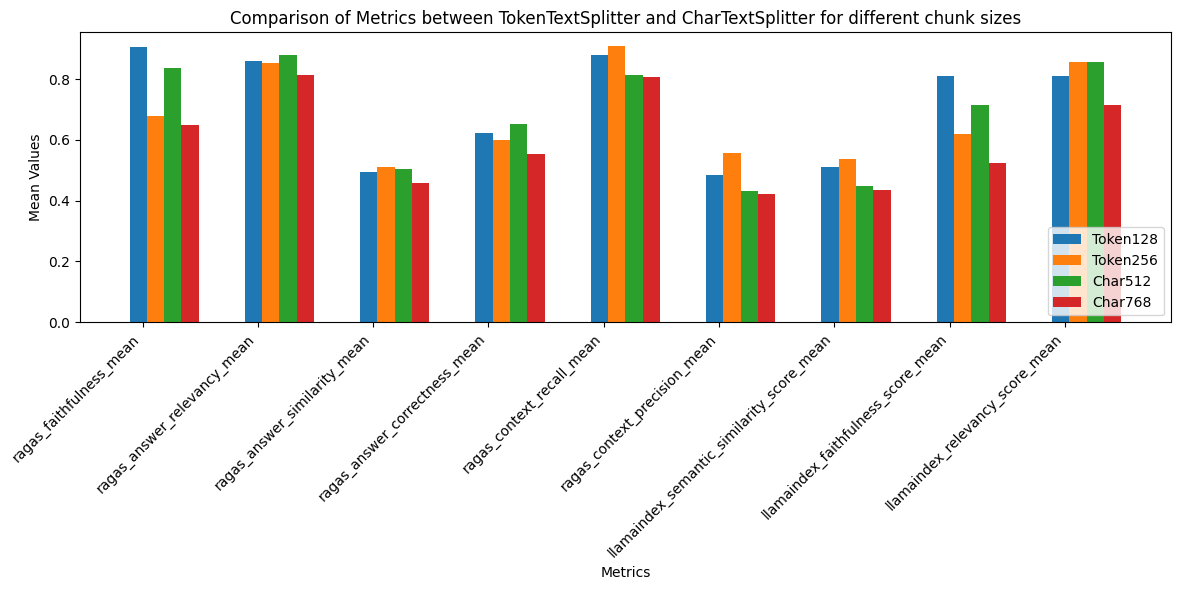

In [55]:
## 1e. Review RecursiveCharacterTextSplitter vs TokenTextSplitter results
import matplotlib.pyplot as plt

# to keep the scale readable, let's filter out LLamaIndex Correctness Score
# Remove the key from the dictionary and get the removed value

if 'llamaindex_correctness_score_mean' in ragas_eval_result1:
    del ragas_eval_result1['llamaindex_correctness_score_mean']
    del ragas_eval_result2['llamaindex_correctness_score_mean']
    del ragas_eval_result3['llamaindex_correctness_score_mean']
    del ragas_eval_result4['llamaindex_correctness_score_mean']

# Extract metric names and mean values
metric_names = list(ragas_eval_result1.keys())
ragas_eval_result1_means = list(ragas_eval_result1.values())
ragas_eval_result2_means = list(ragas_eval_result2.values())
ragas_eval_result3_means = list(ragas_eval_result3.values())
ragas_eval_result4_means = list(ragas_eval_result4.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='Token128')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='Token256')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result3_means, bar_width, label='Char512')
bar4 = ax.bar([i + 3*bar_width for i in index], ragas_eval_result4_means, bar_width, label='Char768')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between TokenTextSplitter and CharTextSplitter for different chunk sizes')
ax.set_xticks([i + bar_width / 4 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


### 1f. Review RecursiveCharacterTextSplitter vs TokenTextSplitter results
Here we can observe the following:
1) RecursiveCharacterTextSplitter with a 512 chunk size consistently performs better than one with a chunk size of 768.
2) Context recall and context precision scores best with a TokenTextSplitter and chunk size 256.
3) Yet, we can also observe the interdependencies between the different metrics. While TokenTextSplitter with a chunk size 256 performs extremely well for context recall, faithfulness is signficantly lower compared to a TokenTextSplitter with a chunk size of 128.

That is why we proceed with TokenTextSplitter with a 128 token chunk size for the next round of evals.

### 8.2) Evaluate impact of different embeddings models

In this second eval, we proceed with the TokenTextSplitter, leave the  everything else constannt, and only change the embeddings models.

In [57]:
# 2. Embedding model: amazon.titan-embed-text-v1 vs cohere.embed-multilingual-v3
## 2a. Create RAG system with amazon.titan-embed-text-v1
from langchain.embeddings import BedrockEmbeddings

token_text_splitter = TokenTextSplitter(chunk_size=128, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="amazon.titan-embed-text-v1"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1536",
    "index_dimension": 1536,
    "embedding_model_name": 'amazon.titan-embed-text-v1',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result5 = run_ragas_eval(rag_system_eval_details, rag_system_details)


TokenTextSplitter split documents in to 904 chunks.



Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
## 2b. Create RAG system with cohere.embed-multilingual-v3
from langchain.embeddings import BedrockEmbeddings

token_text_splitter = TokenTextSplitter(chunk_size=128, chunk_overlap=64) 
token_text_list = token_text_splitter.split_documents(documents)  
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)


rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": "",
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result6 = run_ragas_eval(rag_system_eval_details, rag_system_details)

In [ ]:
# 2c. Review Embedding model: amazon.titan-embed-text-v1 vs cohere.embed-multilingual-v3 results

import matplotlib.pyplot as plt

# to keep the scale readable, let's filter out LLamaIndex Correctness Score
# Remove the key from the dictionary and get the removed value
if 'llamaindex_correctness_score_mean' in ragas_eval_result5:
    del ragas_eval_result5['llamaindex_correctness_score_mean']
    del ragas_eval_result6['llamaindex_correctness_score_mean']

# Extract metric names and mean values
metric_names = list(ragas_eval_result3.keys())
ragas_eval_result5_means = list(ragas_eval_result5.values())
ragas_eval_result6_means = list(ragas_eval_result6.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result5_means, bar_width, label='amazon.titan-embed-text-v1')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result6_means, bar_width, label='cohere.embed-multilingual-v3')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between amazon.titan-embed-text-v1 and cohere.embed-multilingual-v3')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

### 2c. Review Embedding model: amazon.titan-embed-text-v1 vs cohere.embed-multilingual-v3 results
For the given chunk size and splitter method, Cohere's embeddings model performs significantly better considering context recall and context precision.
Thus we will continue the next round of evaluation with Cohere's embeddings model.

### 8.3) Evaluate impact of different retriever search types

In [ ]:
# 3. retriever: OpenSearch VectoreStoreRetriever search types “similarity” vs “mmr” vs KnowledgeBase Retriever
## 3a. Create RAG system with “similarity”
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": vector_store,
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "similarity", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result7 = run_ragas_eval(rag_system_eval_details, rag_system_details)

In [ ]:
## 3b. Create RAG system with mmr
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": vector_store,
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "mmr", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result8 = run_ragas_eval(rag_system_eval_details, rag_system_details)

In [ ]:
## 3c. Create RAG system with Bedrock Knowledge Base retriever
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": vector_store,
    "llm": llm01,
    "kb_id": os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "mmr", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result9 = run_ragas_eval(rag_system_eval_details, rag_system_details)

In [ ]:
# 3d. Review “similarity” vs “mmr” vs Bedrock Knowledge Base retriever results

import matplotlib.pyplot as plt

# to keep the scale readable, let's filter out LLamaIndex Correctness Score
# Remove the key from the dictionary and get the removed value
if 'llamaindex_correctness_score_mean' in ragas_eval_result7:
    del ragas_eval_result7['llamaindex_correctness_score_mean']
    del ragas_eval_result8['llamaindex_correctness_score_mean']
    del ragas_eval_result9['llamaindex_correctness_score_mean']

# Extract metric names and mean values
metric_names = list(ragas_eval_result7.keys())
ragas_eval_result7_means = list(ragas_eval_result7.values())
ragas_eval_result8_means = list(ragas_eval_result8.values())
ragas_eval_result9_means = list(ragas_eval_result9.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result7_means, bar_width, label='similarity')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result8_means, bar_width, label='mmr')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result9_means, bar_width, label='bedrock_kb_retriever')
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between “similarity” vs “mmr” vs Bedrock Knowledge Base retriever')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

### 3d. Review “similarity” vs “mmr” vs Bedrock Knowledge Base retriever results
Metrics such as faithfullness are still low, but improved with mmr.



### 8.4) Evaluate impact of different prompt templates

In [ ]:
# 4. Prompt Template: For each LLM we evaluate two different prompt templates
## 4a. Create RAG system with PROMPT_CLAUDE_1
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": vector_store,
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_1",
    "prompt_template": PROMPT_CLAUDE_1,
    "chain_type": "stuff",
    "search_type": "mmr", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result10 = run_ragas_eval(rag_system_eval_details, rag_system_details)

In [ ]:
## 4b. Create RAG system with PROMPT_CLAUDE_2
from langchain.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(
    client=bedrock_runtime,
    model_id="cohere.embed-multilingual-v3"
)

rag_system_details = {
    "aospy_client": aospy_client,
    "vector_store": vector_store,
    "llm": llm01,
    "kb_id": "",
    "splitter_name": "TokenTextSplitter",
    "text_chunks": token_text_list,
    "index_name": "rag-eval-tokentextsplitter_1024",
    "index_dimension": 1024,
    "embedding_model_name": 'cohere.embed-multilingual-v3',
    "embedding_model": embedding_model,
    "prompt_template_name": "PROMPT_CLAUDE_2",
    "prompt_template": PROMPT_CLAUDE_2,
    "chain_type": "stuff",
    "search_type": "mmr", # alternative: "mmr", or "similarity_score_threshold" (Default: similarity)
    "retriever_k": 4, # Amount of documents to return (Default: 4)
    "score_threshold": 0, # Minimum relevance threshold for similarity_score_threshold
    "fetch_k": 20, # Amount of documents to pass to MMR algorithm (Default: 20)
    "lambda_mult": 0.5, # Diversity of results returned by MMR, 1 for minimum diversity and 0 for maximum. (Default: 0.5)
         
}
run_name, vector_store, qa_chain = create_rag(rag_system_details)

rag_system_eval_details = {
    "experiment_name": experiment_name,
    "run_name": run_name,
    "qa_chain": qa_chain,
    "ground_truth": prompts
}
ragas_eval_result11 = run_ragas_eval(rag_system_eval_details, rag_system_details)

In [ ]:
# 4c. Review PROMPT_CLAUDE_1 vs PROMPT_CLAUDE_2 results

import matplotlib.pyplot as plt

if 'llamaindex_correctness_score_mean' in ragas_eval_result10:
    del ragas_eval_result10['llamaindex_correctness_score_mean']
    del ragas_eval_result11['llamaindex_correctness_score_mean']
    
# Extract metric names and mean values
metric_names = list(ragas_eval_result10.keys())
ragas_eval_result10_means = list(ragas_eval_result10.values())
ragas_eval_result11_means = list(ragas_eval_result11.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result10_means, bar_width, label='PROMPT_CLAUDE_1')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result11_means, bar_width, label='PROMPT_CLAUDE_2')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between PROMPT_CLAUDE_1 and PROMPT_CLAUDE_2 template')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

### 4c. Review PROMPT_CLAUDE_1 vs PROMPT_CLAUDE_2 results
Prompt Template PROMPT_CLAUDE_2 performed better than PROMPT_CLAUDE_1.


# Conclusion / Things to improve